Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import random
import math

Constants

In [2]:
g_K = 36.0
g_Na = 120.0

In [3]:
E_K = -77.0
E_Na = 50.0

In [4]:
E = dict(A = -65.0, B = 55.0)

In [5]:
Cm = 1.0

In [6]:
K = dict(A = 1 / (128 * 1e-9), B = 1 / (500 * 1e-9))

In [7]:
gam = dict(A = 8 * 1e-3, B = 10 * 1e-3)

Initial state

In [8]:
Vm_0 = -76.0 #mV

Equations for m, n и h:


In [9]:
def alpha_n(V):
    return (0.01 * (V + 55)) / (1 - np.exp(-0.1 * (V + 55)))

def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65))

def alpha_m(V):
    return (0.1 * (V+ 40)) / (1 - np.exp(-0.1 * (V + 40)))

def beta_m(V):
    return 4 * np.exp(-0.0556 * (V + 65))

def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65))

def beta_h(V):
    return 1.0 / (1 + np.exp(-0.1 * (V + 35)))

def n_inf(V=Vm_0):
    return alpha_n(V) / (alpha_n(V) + beta_n(V))

def m_inf(V=Vm_0):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))

def h_inf(V=Vm_0):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))

Derivatives

In [10]:
def compute_derivatives(y, t0):
    dy = np.zeros((8,))
    
    V = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    I_K = g_K * np.power(n, 4.0) * (V - E_K)
    I_Na = g_Na * np.power(m, 3.0) * h * (V - E_Na)

    I_A = N['A'] * P(t0, "A") * gam['A'] * (V - E['A'])
    I_B = N['B'] * P(t0, "B") * gam['B'] * (V - E['B'])
    
    dy[0] = - 1 / Cm * (I_K + I_Na + I_A + I_B)
    
    dy[1] = (alpha_n(V) * (1.0 - n)) - (beta_n(V) * n)
    
    dy[2] = (alpha_m(V) * (1.0 - m)) - (beta_m(V) * m)
    
    dy[3] = (alpha_h(V) * (1.0 - h)) - (beta_h(V) * h)

    dy[4] = I_K

    dy[5] = I_Na
    
    dy[6] = I_A

    dy[7] = I_B
    
    return dy

Initial state

In [11]:
Y = np.array([Vm_0, n_inf(), m_inf(), h_inf(), 0, 0, 0, 0])

First simulation - definition of stimulus and lenghts

Computation

In [69]:
t_max = 60
T = [round(t, 2) for t in np.arange(0.0, t_max, 0.01)]

In [70]:
def P(t, syn):
  t_tech = round(t, 2)
  if t_tech < t_max:
    if syn == "A":
      L_t = L[t_tech][0]
    elif syn == "B":
      L_t = L[t_tech][1]
    l = L_t / V[syn]
    P = (l / K[syn]) / (1 + l / K[syn])
    return P
  else:
    return 0.0

In [146]:
L_inc = dict(A = 1000.0, B = 1000.0) #M
L_out = dict(A = 400.0, B = 300.0) #M
V = dict(A = 1000.0, B = 1000.0) #M
N = dict(A = int(7e9), B = int(20e9))
dist = dict(A = [15, 15], B = 0.7)

L_A = np.zeros((len(T)))
L_B = np.zeros((len(T)))

for i in range(1, len(T)):
  L_A[i] = min(max(L_A[i-1] + int(np.random.poisson(dist['A'][0]) > dist['A'][1]) * L_inc['A'] - L_out['A'], 0.0), V['A'])
  L_B[i] = min(max(L_B[i-1] + int(np.random.uniform(0, 1) > dist['B']) * L_inc['B'] - L_out['B'], 0.0), V['B'])

L = dict(zip(T, zip(L_A, L_B)))

In [147]:
Ey = odeint(compute_derivatives, Y, T)

In [126]:
def to_HZ(sol):
    hz = []
    for sec in np.split(sol[:, 0], 60):
        spikes, i = 0, 0
        while i < 99:
            if sec[i] > 0 and sec[i+1] < 0:
                spikes+=1
            i+=1
        hz.append(spikes)
    return hz

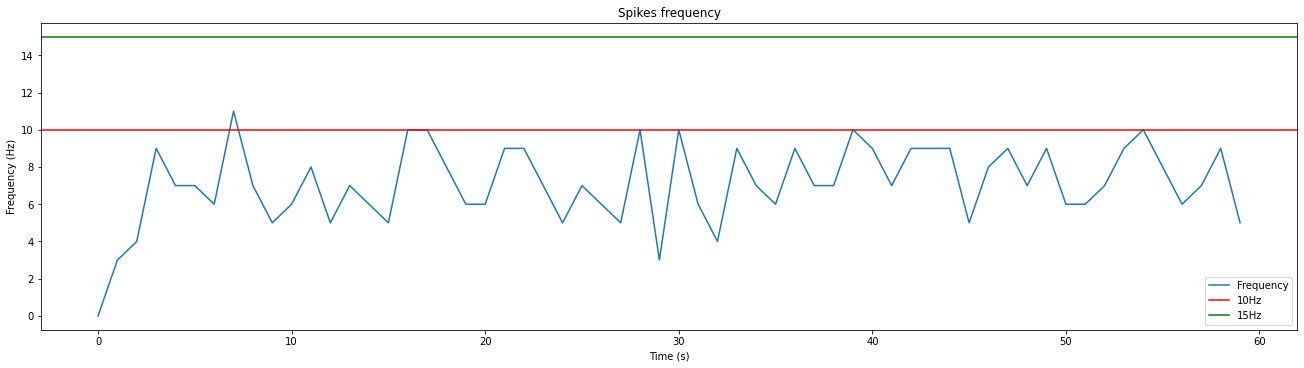

In [148]:
HZ = np.array(to_HZ(Ey))
fig = plt.figure(constrained_layout=True, figsize=(18, 5))
plt.plot(range(0, 60), HZ, label='Frequency')
plt.axhline(y=10, color='r', label='10Hz')
plt.axhline(y=15, color='g', label='15Hz')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spikes frequency')
plt.legend()
plt.show()

Проверка выживаемости котенка:
*   Спайки не реже 5 (500 мс.) секунд - да
*   Нет спайков на частоте 10Гц 20+ секунд - да
*   Нет спайков на частоте 16Гц 5+ секунд - да
*   Частота 10Гц не меньше 5 раз - да
*   Частота 15Гц не меньше 3 раз - нет

Задание 1:

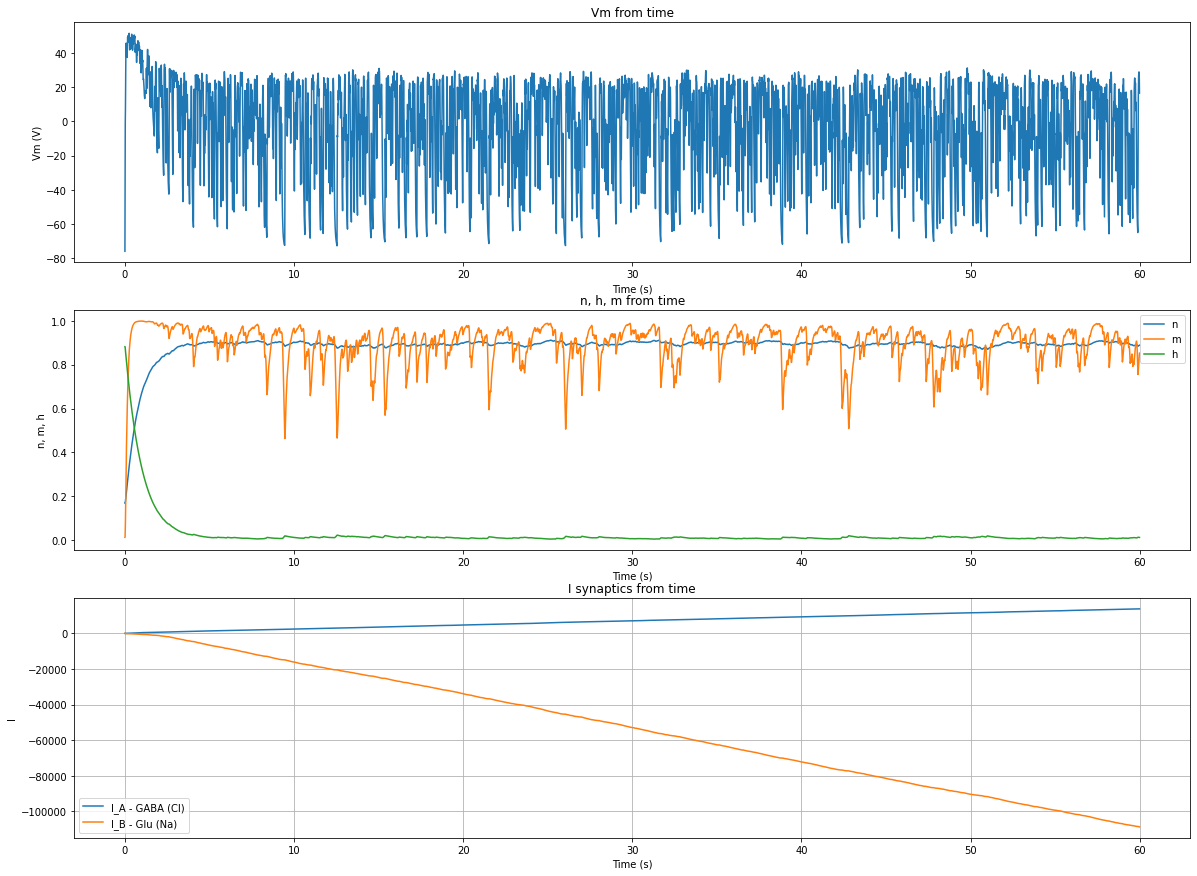

In [149]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (20,15))
ax1.plot(T, Ey[:, 0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Vm (V)')
ax1.set_title('Vm from time')
plt.grid()

ax2.plot(T, Ey[:, 1], label = 'n')
ax2.plot(T, Ey[:, 2], label = 'm')
ax2.plot(T, Ey[:, 3], label = 'h')
ax2.legend()
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('n, m, h')
ax2.set_title('n, h, m from time')
plt.grid()

ax3.plot(T, Ey[:, 6], label = 'I_A - GABA (Cl)')
ax3.plot(T, Ey[:, 7], label = 'I_B - Glu (Na)')
ax3.legend()
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('I')
ax3.set_title('I synaptics from time')
plt.grid()


С увеличением силы тока частота спайков увеличивается, однако, вместе с этим амплитуда уменьшается

Задание 2

Text(0.5, 1.0, 'Vm - h')

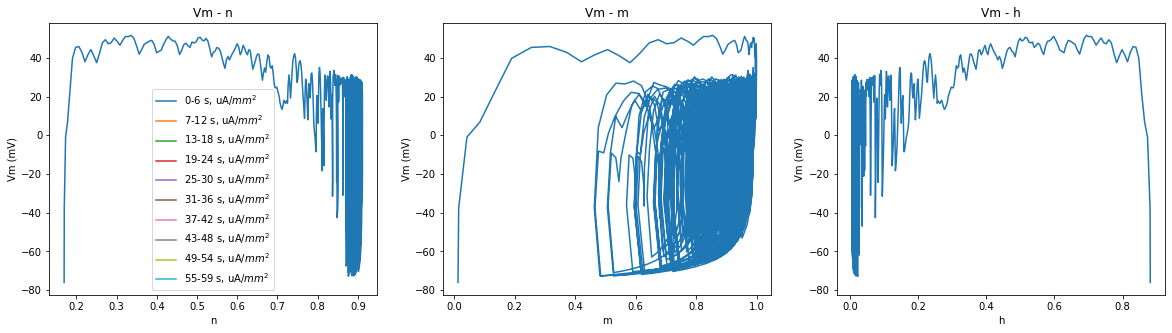

In [156]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(Ey[0:5999, 1], Ey[0:5999, 0], label = str('0-6 s, uA/$mm^2$'))
ax1.plot(Ey[6000:11999, 1], Ey[6000:11999, 0], label = str('7-12 s, uA/$mm^2$'))
ax1.plot(Ey[12000:17999, 1], Ey[12000:17999, 0], label = str('13-18 s, uA/$mm^2$'))
ax1.plot(Ey[18000:23999, 1], Ey[18000:23999, 0], label = str('19-24 s, uA/$mm^2$'))
ax1.plot(Ey[24000:29999, 1], Ey[24000:29999, 0], label = str('25-30 s, uA/$mm^2$'))
ax1.plot(Ey[30000:35999, 1], Ey[30000:35999, 0], label = str('31-36 s, uA/$mm^2$'))
ax1.plot(Ey[36000:41999, 1], Ey[36000:41999, 0], label = str('37-42 s, uA/$mm^2$'))
ax1.plot(Ey[42000:47999, 1], Ey[42000:47999, 0], label = str('43-48 s, uA/$mm^2$'))
ax1.plot(Ey[48000:53999, 1], Ey[48000:53999, 0], label = str('49-54 s, uA/$mm^2$'))
ax1.plot(Ey[54000:59999, 1], Ey[54000:59999, 0], label = str('55-59 s, uA/$mm^2$'))
ax1.legend()
ax1.set_xlabel('n')
ax1.set_ylabel('Vm (mV)')
ax1.set_title('Vm - n')

ax2.plot(Ey[0:5999, 2], Ey[0:5999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[6000:11999, 2], Ey[6000:11999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[12000:17999, 2], Ey[12000:17999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[18000:23999, 2], Ey[18000:23999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[24000:29999, 2], Ey[24000:29999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[30000:35999, 2], Ey[30000:35999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[36000:41999, 2], Ey[36000:41999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[42000:47999, 2], Ey[42000:47999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[48000:53999, 2], Ey[48000:53999, 0], label = str('uA/$mm^2$'))
ax2.plot(Ey[54000:59999, 2], Ey[54000:59999, 0], label = str('uA/$mm^2$'))
ax2.set_xlabel('m')
ax2.set_ylabel('Vm (mV)')
ax2.set_title('Vm - m')

ax3.plot(Ey[0:5999, 3], Ey[0:5999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[6000:11999, 3], Ey[6000:11999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[12000:17999, 3], Ey[12000:17999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[18000:23999, 3], Ey[18000:23999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[24000:29999, 3], Ey[24000:29999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[30000:35999, 3], Ey[30000:35999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[36000:41999, 3], Ey[36000:41999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[42000:47999, 3], Ey[42000:47999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[48000:53999, 3], Ey[48000:53999, 0], label = str('uA/$mm^2$'))
ax3.plot(Ey[54000:59999, 3], Ey[54000:59999, 0], label = str('uA/$mm^2$'))
ax3.set_xlabel('h')
ax3.set_ylabel('Vm (mV)')
ax3.set_title('Vm - h')

Судя по графикам, предельные циклы присутствуют и повторяются для всех 10 промежутков симуляции (по 6 секунд каждый)